In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from scipy.interpolate import splrep, BSpline
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.pyplot import subplots
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import sklearn

%matplotlib inline

# Linear Regression example
## Specify parameters

In [2]:
n = 100
p = 1
beta = 3
sigma = 1
current_dir = os.getcwd()

## Generate data

In [3]:
x = np.random.normal(size=(n, p))
y = x * beta + np.random.normal(size=(n, 1)) * sigma

colnames = ['x' + str(i) for i in range(1, p+1)]
colnames.insert(0, 'y')

df = pd.DataFrame(np.hstack((y, x)), columns = colnames)

## Fit linear regression model using sklearn

In [4]:
lm = LinearRegression()
lm.fit(x, y)
y_hat = lm.predict(x)
resid = y - y_hat

## Plot x vs y using seaborn

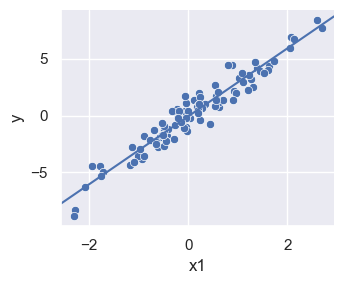

In [5]:
sns.set_theme()
lm_plot = sns.relplot(df, x='x1', y='y', height = 3, aspect = 1.2)
plt.axline((0,lm.intercept_[0]), slope=lm.coef_[0][0])

### Save plot to file

In [23]:
lm_plot.savefig(current_dir + '/lm.png')

## Plot x vs y, including residual distances

/Users/gemma/miniconda3/envs/msds534/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


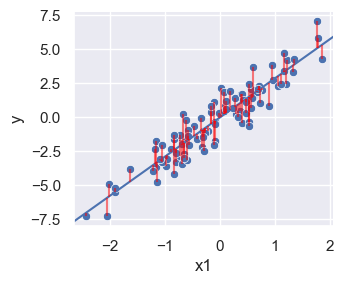

In [27]:
y_min = np.minimum(y, y_hat)
y_max = np.maximum(y, y_hat)
lm_plot = sns.relplot(df, x='x1', y='y', height = 3, aspect = 1.2)
plt.axline((0,lm.intercept_[0]), slope=lm.coef_[0][0])
lm_plot.ax.vlines(x=list(x[:,0]), ymin=list(y_min[:,0]), ymax=list(y_max[:,0]), color = 'red', alpha=0.5)

In [28]:
lm_plot.savefig(current_dir + '/lm_resid.png')

## Overfitting example

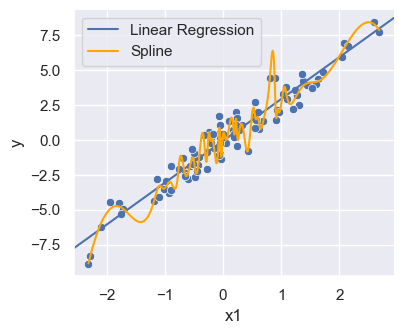

In [8]:
sort_ind = np.argsort(x, axis=0)
xsort = np.take_along_axis(x, sort_ind, axis=0)
ysort = np.take_along_axis(y, sort_ind, axis=0)
tck = splrep(xsort, ysort, s=20)

xspline = np.arange(x.min(), x.max(), 0.01)
yspline = BSpline(*tck)(xspline)

lm_plot = sns.relplot(df, x='x1', y='y', height = 3.5, aspect = 1.2)
plt.axline((0,lm.intercept_[0]), slope=lm.coef_[0][0], label = "Linear Regression")
plt.plot(xspline, yspline,color='orange', label = "Spline")
plt.legend(loc='upper left')

## Shrinkage plot

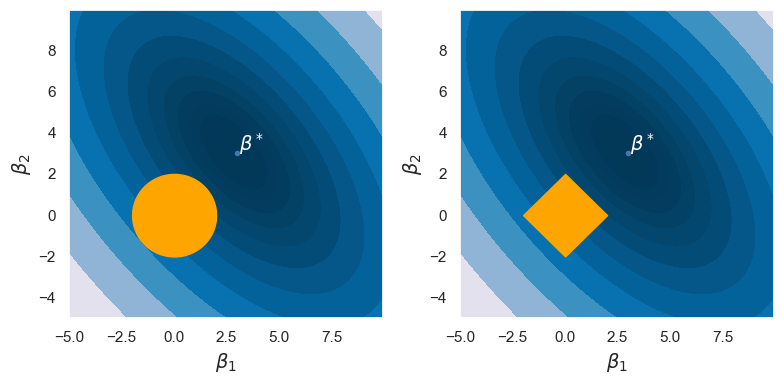

In [9]:
n = 100
p = 90
beta = np.zeros(p)
beta[0]=3
beta[1]=3
cov = 0.6 * np.ones((p, p))
np.fill_diagonal(cov, 1)
x = np.random.multivariate_normal(mean=np.zeros(p), cov=cov, size=n)
y = np.matmul(x, beta) + np.random.normal(size=n)

beta1 = np.arange(-5, 10, 0.05)
beta2 = np.arange(-5, 10, 0.05)

beta_plot = [np.array((i, j)) for i in beta1 for j in beta2]

def ls_func(beta):
    beta_full = np.zeros(p)
    beta_full[0] = beta[0]
    beta_full[1] = beta[1]
    sum_square = 0.5 * np.sum(np.power(y - np.matmul(x, beta_full), 2))
    return sum_square

out = [ls_func(i) for i in beta_plot]

z = np.array(out)
z = np.reshape(z, (len(beta1), len(beta2)))
z = np.transpose(z)

lev_exp = np.linspace(np.log10(z.min()), np.log10(z.max()), num = 15)
levs = np.power(10, lev_exp)

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(8, 4)
cs = ax[0].contourf(beta1, beta2, z, levels=levs, cmap=cm.PuBu_r)
ax[0].plot(beta[0], beta[1], marker = '.', ls='none')
ax[0].annotate(r'$\beta^*$', (beta[0] + 0.1, beta[1] + 0.1), fontsize=14, color='white')
ax[0].set_xlabel(r'$\beta_1$', fontsize=14)
ax[0].set_ylabel(r'$\beta_2$', fontsize=14)

alpha = 2
x_fill = np.linspace(-alpha, alpha, 500)
y_ridge_up = np.sqrt(alpha**2-x_fill**2)
y_ridge_down = -np.sqrt(alpha**2-x_fill**2)
ax[0].fill_between(x_fill, y_ridge_down, y_ridge_up, color='orange')

cs = ax[1].contourf(beta1, beta2, z, levels=levs, cmap=cm.PuBu_r)
ax[1].plot(beta[0], beta[1], marker = '.', ls='none')
ax[1].annotate(r'$\beta^*$', (beta[0] + 0.1, beta[1] + 0.1), fontsize=14, color='white')
ax[1].set_xlabel(r'$\beta_1$', fontsize=14)
ax[1].set_ylabel(r'$\beta_2$', fontsize=14)

x_fill = np.linspace(-alpha, alpha, 500)
y_lasso_up = (x_fill+alpha) * (x_fill < 0) + (-x_fill + alpha) * (x_fill > 0)
y_lasso_down = -(x_fill+alpha) * (x_fill < 0) + -(-x_fill + alpha) * (x_fill > 0)
ax[1].fill_between(x_fill, y_lasso_down, y_lasso_up, color='orange')

fig.tight_layout()
fig.savefig(current_dir + '/ridge_vs_lasso.pdf')


## Lasso example (adapted from https://github.com/intro-stat-learning/ISLP_labs/blob/stable/Ch06-varselect-lab.ipynb)

In [16]:
n = 100
p = 90
beta = np.zeros(p)
beta[0]=3
beta[1]=3
cov = 0.6 * np.ones((p, p))
np.fill_diagonal(cov, 1)
x = np.random.multivariate_normal(mean=np.zeros(p), cov=cov, size=n)
y = np.matmul(x, beta) + np.random.normal(size=n)

x_columns = ['x' + str(i+1) for i in range(p)]

In [19]:
# set up cross-validation
K=5
kfold = sklearn.model_selection.KFold(K,random_state=0,shuffle=True)

# function to standardize input
scaler = StandardScaler(with_mean=True, with_std=True)

In [26]:
lassoCV = sklearn.linear_model.ElasticNetCV(n_alphas=100, l1_ratio=1,cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),('lasso', lassoCV)])
pipeCV.fit(x, y)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_

lambdas, soln_array = sklearn.linear_model.Lasso.path(x, y,l1_ratio=1,n_alphas=100)[:2]
soln_path = pd.DataFrame(soln_array.T,columns=x_columns, index=-np.log(lambdas))

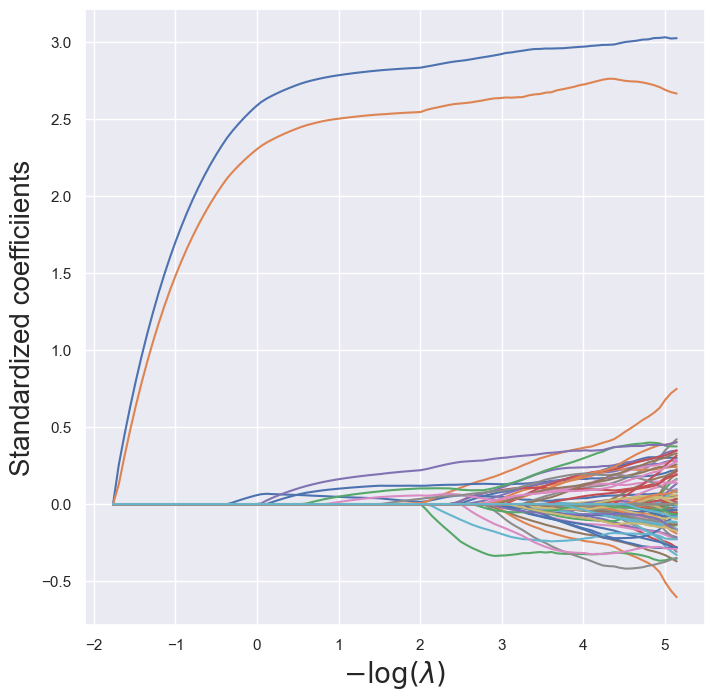

In [27]:
path_fig, ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficiients', fontsize=20);

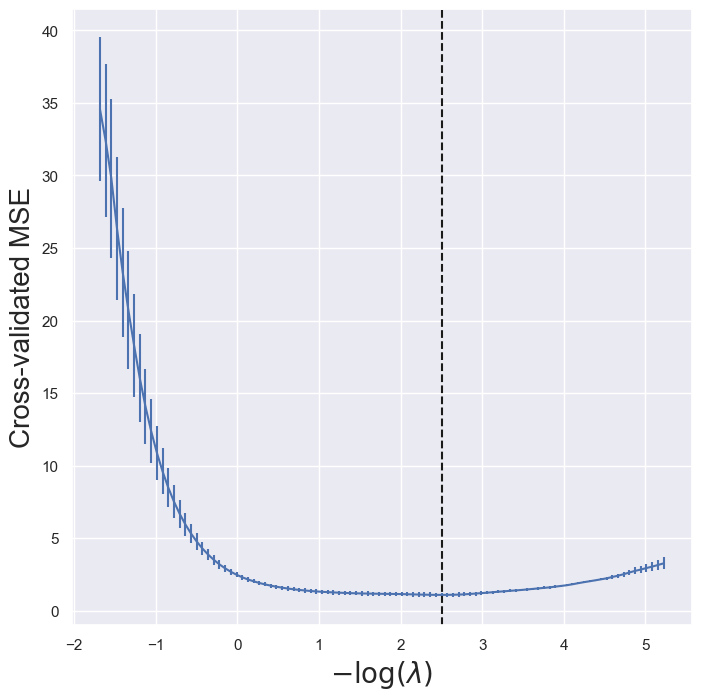

In [28]:
lassoCV_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(tuned_lasso.alphas_),tuned_lasso.mse_path_.mean(1),yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);

## Ridge regression  (adapted from https://github.com/intro-stat-learning/ISLP_labs/blob/stable/Ch06-varselect-lab.ipynb)

In [38]:
lambdas = 10**np.linspace(8, -2, 100) / y.std()
ridgeCV = sklearn.linear_model.ElasticNetCV(alphas=lambdas, 
                           l1_ratio=0,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('ridge', ridgeCV)])
pipeCV.fit(x, y)

/Users/gemma/miniconda3/envs/msds534/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.459e+03, tolerance: 2.918e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/gemma/miniconda3/envs/msds534/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.458e+03, tolerance: 2.918e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using o

/Users/gemma/miniconda3/envs/msds534/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.295e+03, tolerance: 2.918e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/gemma/miniconda3/envs/msds534/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.259e+03, tolerance: 2.918e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using o

/Users/gemma/miniconda3/envs/msds534/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.840e+02, tolerance: 2.918e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/gemma/miniconda3/envs/msds534/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.638e+02, tolerance: 2.918e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using o

/Users/gemma/miniconda3/envs/msds534/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.775e+01, tolerance: 2.918e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/gemma/miniconda3/envs/msds534/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.502e+01, tolerance: 2.918e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using o

/Users/gemma/miniconda3/envs/msds534/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.418e+03, tolerance: 2.855e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/gemma/miniconda3/envs/msds534/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.416e+03, tolerance: 2.855e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using o

/Users/gemma/miniconda3/envs/msds534/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.262e+02, tolerance: 2.855e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/gemma/miniconda3/envs/msds534/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.584e+02, tolerance: 2.855e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using o

/Users/gemma/miniconda3/envs/msds534/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.302e+02, tolerance: 2.855e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/gemma/miniconda3/envs/msds534/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.154e+02, tolerance: 2.855e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using o

/Users/gemma/miniconda3/envs/msds534/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.521e+00, tolerance: 2.855e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/gemma/miniconda3/envs/msds534/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.026e+00, tolerance: 2.855e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using o

/Users/gemma/miniconda3/envs/msds534/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.463e+03, tolerance: 3.090e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/gemma/miniconda3/envs/msds534/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.443e+03, tolerance: 3.090e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using o

/Users/gemma/miniconda3/envs/msds534/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.602e+02, tolerance: 3.090e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/gemma/miniconda3/envs/msds534/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.310e+02, tolerance: 3.090e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using o

/Users/gemma/miniconda3/envs/msds534/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.041e+01, tolerance: 3.090e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/gemma/miniconda3/envs/msds534/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.559e+01, tolerance: 3.090e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using o

/Users/gemma/miniconda3/envs/msds534/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.236e+03, tolerance: 2.474e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/gemma/miniconda3/envs/msds534/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.235e+03, tolerance: 2.474e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using o

/Users/gemma/miniconda3/envs/msds534/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.707e+02, tolerance: 2.474e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/gemma/miniconda3/envs/msds534/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.409e+02, tolerance: 2.474e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using o

/Users/gemma/miniconda3/envs/msds534/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.158e+01, tolerance: 2.474e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/gemma/miniconda3/envs/msds534/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.534e+01, tolerance: 2.474e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using o

/Users/gemma/miniconda3/envs/msds534/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.399e+03, tolerance: 2.800e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/gemma/miniconda3/envs/msds534/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.398e+03, tolerance: 2.800e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using o

/Users/gemma/miniconda3/envs/msds534/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.322e+03, tolerance: 2.800e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/gemma/miniconda3/envs/msds534/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.304e+03, tolerance: 2.800e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using o

/Users/gemma/miniconda3/envs/msds534/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.639e+02, tolerance: 2.800e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/gemma/miniconda3/envs/msds534/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.381e+02, tolerance: 2.800e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using o

/Users/gemma/miniconda3/envs/msds534/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.846e+01, tolerance: 2.800e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/gemma/miniconda3/envs/msds534/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.385e+01, tolerance: 2.800e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using o

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge',
                 ElasticNetCV(alphas=array([1.68106317e+07, 1.33221381e+07, 1.05575666e+07, 8.36669100e+06,
       6.63045953e+06, 5.25452579e+06, 4.16412182e+06, 3.29999533e+06,
       2.61518987e+06, 2.07249324e+06, 1.64241545e+06, 1.30158616e+06,
       1.03148477e+06, 8.17434041e+05, 6.47802498e+05, 5.13372401e+05,
       4.06838849e+05, 3.22412830e+05,...
       1.39564817e-01, 1.10602731e-01, 8.76507729e-02, 6.94617385e-02,
       5.50472399e-02, 4.36239962e-02, 3.45712709e-02, 2.73971410e-02,
       2.17117657e-02, 1.72062030e-02, 1.36356216e-02, 1.08059970e-02,
       8.56356779e-03, 6.78648102e-03, 5.37817015e-03, 4.26210787e-03,
       3.37764760e-03, 2.67672796e-03, 2.12126113e-03, 1.68106317e-03]),
                              cv=KFold(n_splits=5, random_state=0, shuffle=True),
                              l1_ratio=0))])

/Users/gemma/miniconda3/envs/msds534/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/gemma/miniconda3/envs/msds534/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1787.1622532218792, tolerance: 0.3574336678728705
  model = cd_fast.enet_coordinate_descent_gram(
/Users/gemma/miniconda3/envs/msds534/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/gemma/miniconda3/envs/msds534/lib/py

/Users/gemma/miniconda3/envs/msds534/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1688.0506617720837, tolerance: 0.3574336678728705
  model = cd_fast.enet_coordinate_descent_gram(
/Users/gemma/miniconda3/envs/msds534/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/gemma/miniconda3/envs/msds534/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1664.2859396631566, tolerance: 0.3574336678728705
  model = cd_fast.enet_coordinate_descent_gram(
/Users/gemma/miniconda3/envs/ms

/Users/gemma/miniconda3/envs/msds534/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.65206180478708, tolerance: 0.3574336678728705
  model = cd_fast.enet_coordinate_descent_gram(
/Users/gemma/miniconda3/envs/msds534/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/gemma/miniconda3/envs/msds534/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.5279924770643, tolerance: 0.3574336678728705
  model = cd_fast.enet_coordinate_descent_gram(
/Users/gemma/miniconda3/envs/msds5

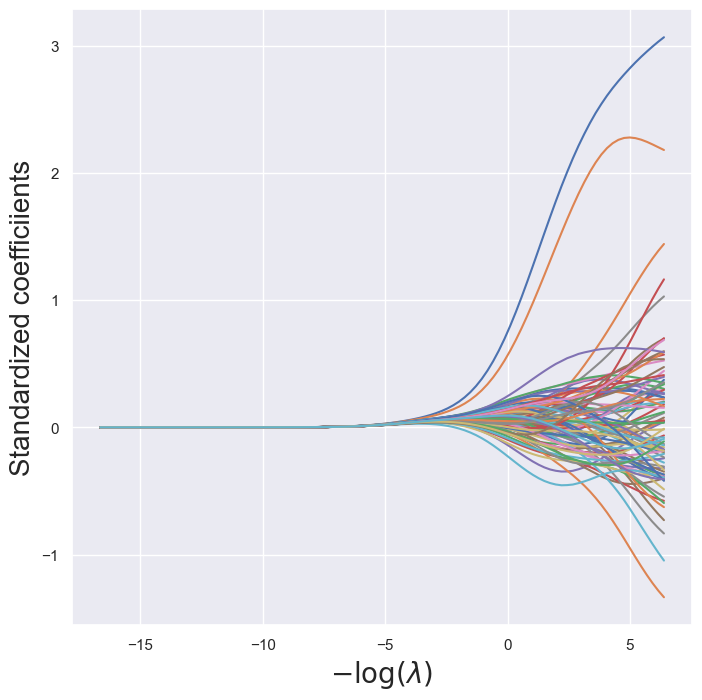

In [37]:
lambdas, soln_array = sklearn.linear_model.ElasticNet.path(x, y,l1_ratio=0,alphas=lambdas)[:2]
soln_path = pd.DataFrame(soln_array.T,columns=x_columns, index=-np.log(lambdas))

path_fig, ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficiients', fontsize=20);

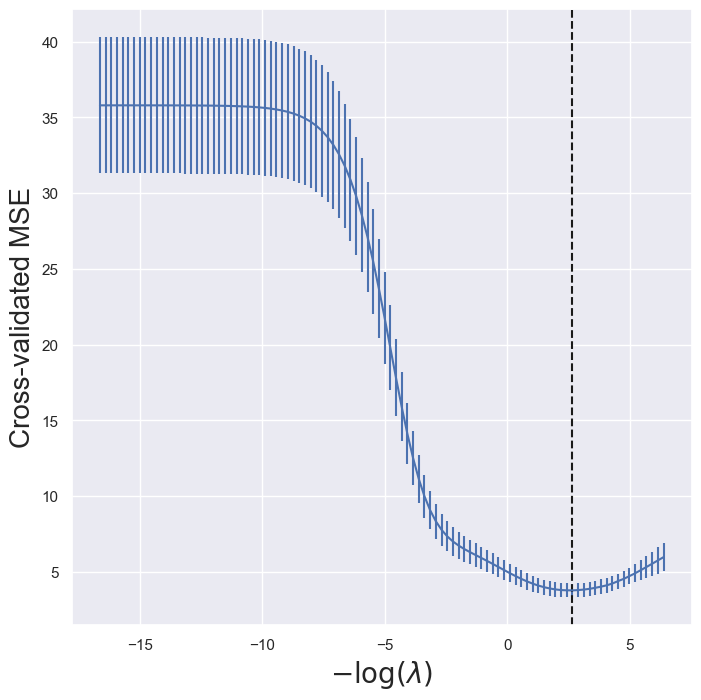

In [34]:
tuned_ridge = pipeCV.named_steps['ridge']
ridgeCV_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
            tuned_ridge.mse_path_.mean(1),
            yerr=tuned_ridge.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_ridge.alpha_), c='k', ls='--')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);


## Logistic regression
### Data

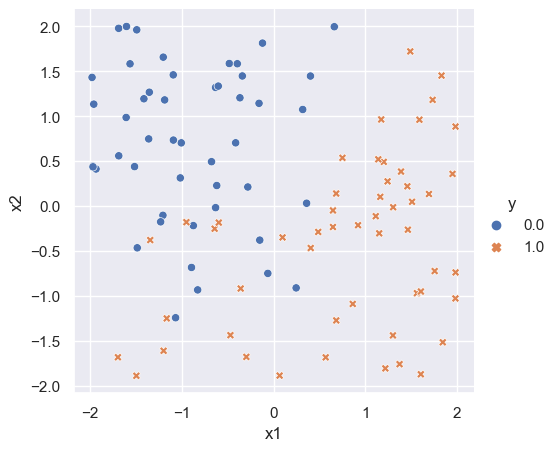

In [10]:
n = 100
p = 2
x = np.random.uniform(-2, 2, size=(n, p))

beta = np.array([2.5, -2.5])
mu = np.matmul(x, beta)
prob = 1/(1 + np.exp(-mu))

y = np.zeros((n))
for i in range(n):
    y[i] = np.random.binomial(1, prob[i], 1)[0]

df = np.hstack([y.reshape((n, 1)), x])
df = pd.DataFrame(df, columns = ['y', 'x1', 'x2'])

sns.set_theme()
logit_plot = sns.relplot(df, x='x1', y='x2', hue='y', style='y')
logit_plot.fig.subplots_adjust(top=.9)
logit_plot.savefig(current_dir + '/logistic.png')


### Fitting the logistic regression model

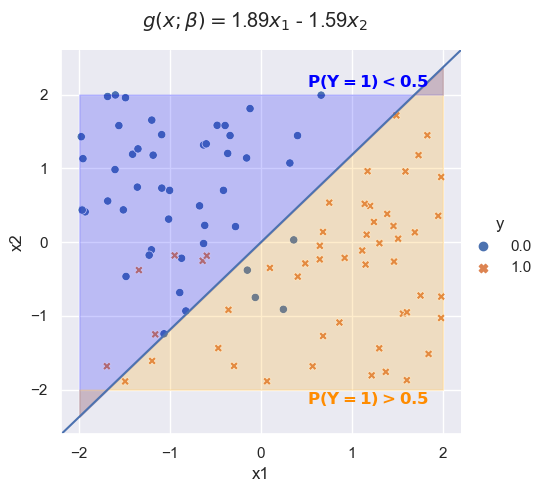

In [11]:
log_fit = LogisticRegression()
log_fit.fit(x, y)
coeffs = log_fit.coef_[0]
coeff = -coeffs[0]/coeffs[1]

## plot
logit_plot = sns.relplot(df, x='x1', y='x2', hue='y', style='y')
plt.axline([0,0], slope=coeff)
## title
logit_plot.fig.subplots_adjust(top=.9)
logit_plot.fig.suptitle(r'$g(x;\beta) = $' + str(round(coeffs[0], 2)) + r'$x_1$ - ' + str(round(-coeffs[1], 2)) + r'$x_2$')
## fill in area
x_fill = np.linspace(-2, 2, num=200)
y_line = coeff * x_fill
logit_plot.ax.fill_between(x_fill, y_line, 2, color='blue', alpha=0.2)
logit_plot.ax.fill_between(x_fill, -2, y_line, color='orange', alpha=0.2)

logit_plot.ax.annotate(r'$\bf P(Y=1)<0.5$', (0.5, 2.1), color='blue')
logit_plot.ax.annotate(r'$\bf P(Y=1)>0.5$', (0.5, -2.2), color='darkorange')

logit_plot.savefig(current_dir + '/logistic_fit.png')


## Principal Components Analysis

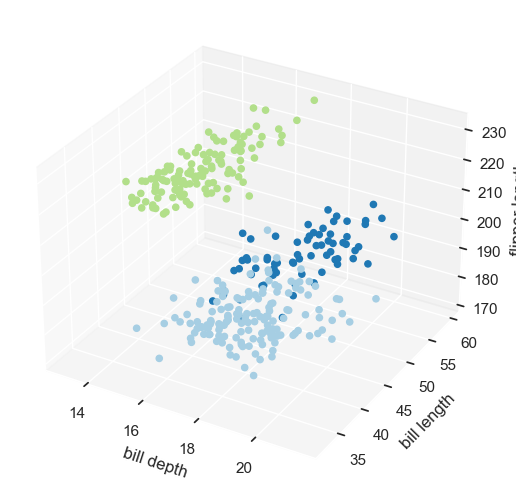

In [12]:
penguins = sns.load_dataset("penguins")

fig = plt.figure()

ax = Axes3D(fig)
fig.add_axes(ax)

cmap = matplotlib.colors.ListedColormap(sns.color_palette("Paired", 3))

cols = penguins['species'].copy()
cols[cols=='Adelie']=1
cols[cols=='Chinstrap']=2
cols[cols=='Gentoo']=3

sc = ax.scatter3D(penguins['bill_depth_mm'],
                penguins['bill_length_mm'],
                penguins['flipper_length_mm'],
                c = cols,
                cmap=cmap,
                alpha=1)
ax.set_xlabel('bill depth')
ax.set_ylabel('bill length')
ax.set_zlabel('flipper length')
ax.set_facecolor((1.0, 1.0, 1.0, 0.0))

fig.savefig(current_dir + '/penguins3d.pdf')

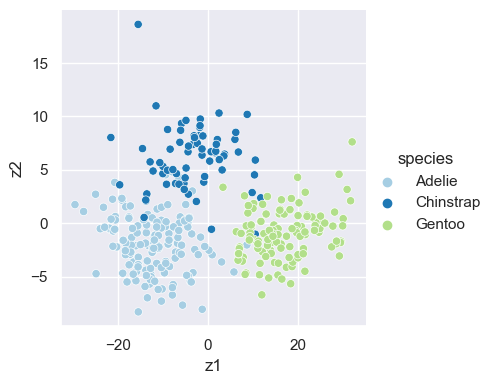

In [13]:
x = penguins[['bill_depth_mm', 'bill_length_mm', 'flipper_length_mm']]
x = x.dropna(axis=0)

pca_fit = PCA()
pca_fit.fit(x)
z = pca_fit.transform(x)

z_df = pd.DataFrame(z[:, 0:2], columns = ['z1', 'z2'])
z_df['species']=penguins['species']

sns.set_theme()
pca_plot = sns.relplot(z_df, x='z1', y='z2', hue='species', palette=sns.color_palette("Paired", 3), height=4)
pca_plot.savefig(current_dir + '/penguins_pca.pdf')

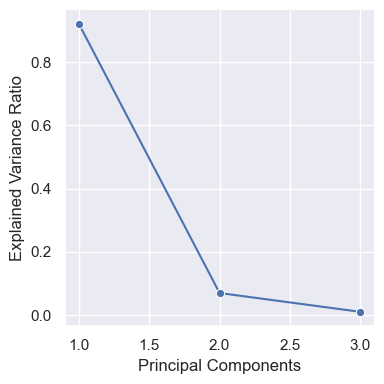

In [14]:
PC_values = np.linspace(1,3,3).reshape(3,1)
scree_df = np.hstack([PC_values, pca_fit.explained_variance_ratio_.reshape(3,1)])
scree_df = pd.DataFrame(scree_df, columns = ['Principal Components', 'Explained Variance Ratio'])
scree_plot = sns.relplot(scree_df, x='Principal Components', y='Explained Variance Ratio', marker='o', kind='line', height=4)

scree_plot.savefig(current_dir + '/scree_plot.pdf')